In [1]:
%pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import skfuzzy as fuzz


import joblib
from joblib import Parallel, delayed

import cv2
import matplotlib.pyplot as plt

In [2]:
path_train_glioma = os.path.join("agyikepek_4_osztaly", "Training", "glioma")
path_train_meningioma = os.path.join("agyikepek_4_osztaly", "Training", "meningioma")
path_train_notumor = os.path.join("agyikepek_4_osztaly", "Training", "notumor")
path_train_pituitary = os.path.join("agyikepek_4_osztaly", "Training", "pituitary")

path_test_glioma = os.path.join("agyikepek_4_osztaly", "Testing", "glioma")
path_test_meningioma = os.path.join("agyikepek_4_osztaly", "Testing", "meningioma")
path_test_notumor = os.path.join("agyikepek_4_osztaly", "Testing", "notumor")
path_test_pituitary = os.path.join("agyikepek_4_osztaly", "Testing", "pituitary")

In [3]:
IMG_SIZE = (64, 64)

IMG_METHODS = []

In [4]:
def save_images(PATH, type, img_size) -> pd.DataFrame:

    df = pd.DataFrame(columns=["img", "type"])

    for file in os.listdir(PATH):
        fname = os.path.join(PATH, file)
        img = cv2.resize(cv2.imread(fname), img_size)      


        temp_df = pd.DataFrame({"img": [img], "type": [type], "file" : [file]})
        
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

In [5]:
train_glioma_df = save_images(path_train_glioma, "glioma", IMG_SIZE)
train_meningioma_df = save_images(path_train_meningioma, "meningioma", IMG_SIZE)
train_notumor_df = save_images(path_train_notumor, "notumor", IMG_SIZE)
train_pituitary_df = save_images(path_train_pituitary, "pituitary", IMG_SIZE)

test_glioma_df = save_images(path_test_glioma, "glioma", IMG_SIZE)
test_meningioma_df = save_images(path_test_meningioma, "meningioma", IMG_SIZE)
test_notumor_df = save_images(path_test_notumor, "notumor", IMG_SIZE)
test_pituitary_df = save_images(path_test_pituitary, "pituitary", IMG_SIZE)
#1m30s

In [6]:
train_df = pd.concat([train_glioma_df, train_meningioma_df, train_notumor_df, train_pituitary_df], axis=0)

In [7]:
print("Train categories and counts: ")
train_df["type"].value_counts()

Train categories and counts: 


type
notumor       1595
pituitary     1344
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [8]:
test_df = pd.concat([test_glioma_df, test_meningioma_df, test_notumor_df, test_pituitary_df], axis=0)

In [9]:
print("Test categories and counts: ")
test_df["type"].value_counts()

Test categories and counts: 


type
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64

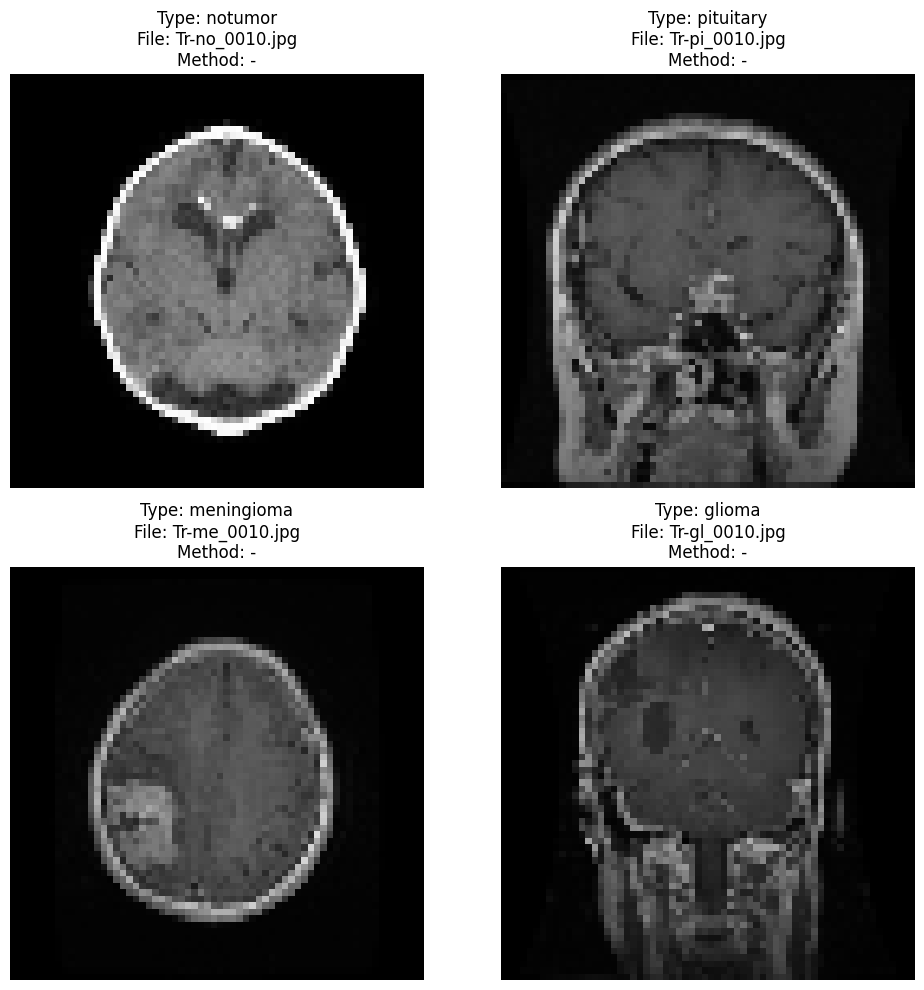

In [10]:
types = ["notumor", "pituitary", "meningioma", "glioma"]
sampled_images = [train_df[train_df["type"] == t].iloc[10] for t in types]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for idx, ax in enumerate(ax.flatten()):
    img = sampled_images[idx]["img"]
    img_type = sampled_images[idx]["type"]
    file_name = sampled_images[idx]["file"]

    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Type: {img_type}\nFile: {file_name}\nMethod: -")

plt.tight_layout()
plt.show()


In [11]:
def sobel_edge_detection(img: np.ndarray) -> np.ndarray:

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)

    sobel_edges = cv2.magnitude(sobel_x, sobel_y)
    return sobel_edges

In [12]:
def fuzzy_cmeans(img: np.ndarray, k=6, med_blur=1) -> np.ndarray:
    if img.ndim == 3:
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        image = img
    
    pixel_vals = image.reshape((-1, img.shape[-1] if img.ndim == 3 else 1)).astype(np.float32)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    
    _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 5, cv2.KMEANS_PP_CENTERS)
    
    segmented_image = centers[labels.flatten()].reshape(image.shape).astype(np.uint8)
    
    if med_blur > 1:
        segmented_image = cv2.medianBlur(segmented_image, med_blur)
    
    return segmented_image

In [13]:
def kirsch_edge_detection(img: np.ndarray) -> np.ndarray:
    base_kernel = np.array([[-3, -3, 5],
                            [-3, 0, 5],
                            [-3, -3, 5]])
    
    kernels = [np.rot90(base_kernel, k=i) for i in range(8)][0]
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    responses = [cv2.filter2D(img_gray, -1, kernel) for kernel in kernels]
    
    kirsch_edges = np.max(responses, axis=0)
    
    return kirsch_edges


In [14]:
def morphological_operations(img: np.ndarray, operation: str, kernel_size: int = 3) -> np.ndarray:
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if operation == 'dilate':
        result = cv2.dilate(img_gray, kernel, iterations=1)
    elif operation == 'erode':
        result = cv2.erode(img_gray, kernel, iterations=1)
    elif operation == 'open':
        result = cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        result = cv2.morphologyEx(img_gray, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError(f"Invalid operation: {operation}. Choose from 'dilate', 'erode', 'open', 'close'.")
    
    return result

In [15]:
def canny_edge_detection(img: np.ndarray, th1: int = 100, th2: int = 200) -> np.ndarray:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blurred_img = cv2.GaussianBlur(img_gray, (5, 5), 0)

    edges = cv2.Canny(blurred_img, th1, th2)
    return edges

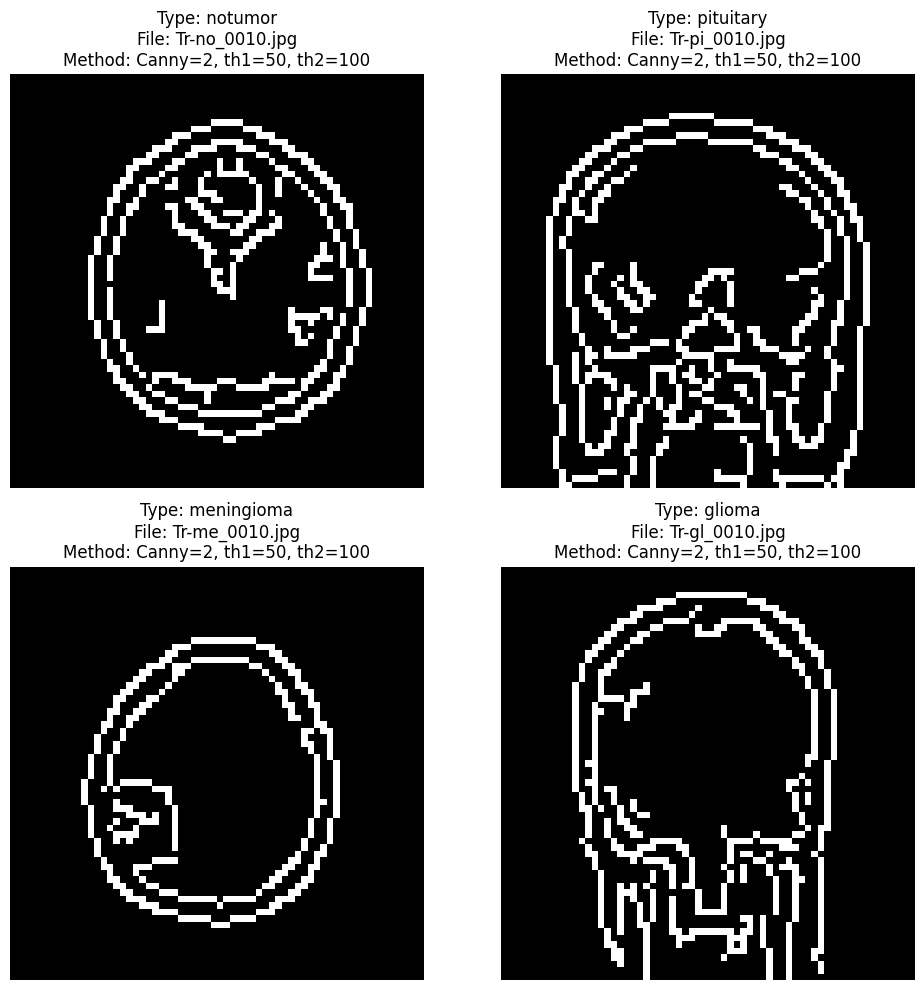

In [16]:
types = ["notumor", "pituitary", "meningioma", "glioma"]
sampled_images = [train_df[train_df["type"] == t].iloc[10] for t in types]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for idx, ax in enumerate(ax.flatten()):
    image = canny_edge_detection(cv2.cvtColor(sampled_images[idx]["img"], cv2.COLOR_BGR2RGB), th1=50, th2=100)
    img_type = sampled_images[idx]["type"]
    file_name = sampled_images[idx]["file"]

    ax.imshow(image, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Type: {img_type}\nFile: {file_name}\nMethod: Canny=2, th1=50, th2=100")

    
plt.tight_layout()
plt.show()

In [17]:
def apply_thresholding(img: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th1 = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    th2 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    th3 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    return th1, th2, th3

In [18]:
PCA_COMPONENTS = 100
N_JOBS = -1

IMG_SIZES = ((32, 32), (64, 64), (128, 128))

## Adding preprocessed images to images list

In [19]:
def prepare_thresholded_data(dataframes, labels):
    images = []
    y = []
    
    for df, label in zip(dataframes, labels):
        print(label)
        for img in df["img"]:

            features = []

            sobel = sobel_edge_detection(img)
            features.append(sobel.ravel())

            kirsch = kirsch_edge_detection(img)
            features.append(kirsch.ravel())

            operation = "open"
            morph = morphological_operations(img, operation)
            features.append(morph.ravel())

            # better without these!!

            # operation = "close"
            # morph = morphological_operations(img, operation)
            # features.append(morph.ravel())

            # operation = "dilate"
            # morph = morphological_operations(img, operation)
            # features.append(morph.ravel())

            canny = canny_edge_detection(img, 100, 210)
            features.append(canny.ravel())

            # fuzzy = fuzzy_cmeans(img)
            # features.append(fuzzy.ravel())
 
            # features.append(img.ravel())

            image_features = np.hstack(features)
            images.append(image_features)

            y.append(label)
    
    X = np.vstack(images)
    y = np.array(y)
    return X, y

train_dataframes = [train_glioma_df, train_meningioma_df, train_notumor_df, train_pituitary_df]
train_labels = ["glioma", "meningioma", "notumor", "pituitary"]

X_train_images, y_train = prepare_thresholded_data(train_dataframes, train_labels)


glioma
meningioma
notumor
pituitary


In [20]:
X_train_images[0].__len__()

16384

In [24]:
# Dimensionality Reduction
pca = PCA(n_components=PCA_COMPONENTS)
X_train_pca = pca.fit_transform(X_train_images)
print(X_train_pca.shape)
#1m10s

(5599, 100)


In [25]:
test_dataframes = [test_glioma_df, test_meningioma_df, test_notumor_df, test_pituitary_df]
test_labels = ["glioma", "meningioma", "notumor", "pituitary"]
X_test_images, y_test = prepare_thresholded_data(test_dataframes, test_labels)

# X_test = Parallel(n_jobs=N_JOBS)(delayed(compute_hog)(img) for img in X_test_images)
# X_test = np.array(X_test)

X_test_pca = pca.transform(X_test_images) #1m10s

glioma
meningioma
notumor
pituitary


In [26]:
X_test_pca = pca.transform(X_test_images) #1m10s

              precision    recall  f1-score   support

      glioma    0.93443   0.76000   0.83824       300
  meningioma    0.78144   0.85294   0.81563       306
     notumor    0.94824   0.99506   0.97108       405
   pituitary    0.91883   0.94333   0.93092       300

    accuracy                        0.89626      1311
   macro avg    0.89573   0.88783   0.88897      1311
weighted avg    0.89941   0.89626   0.89521      1311



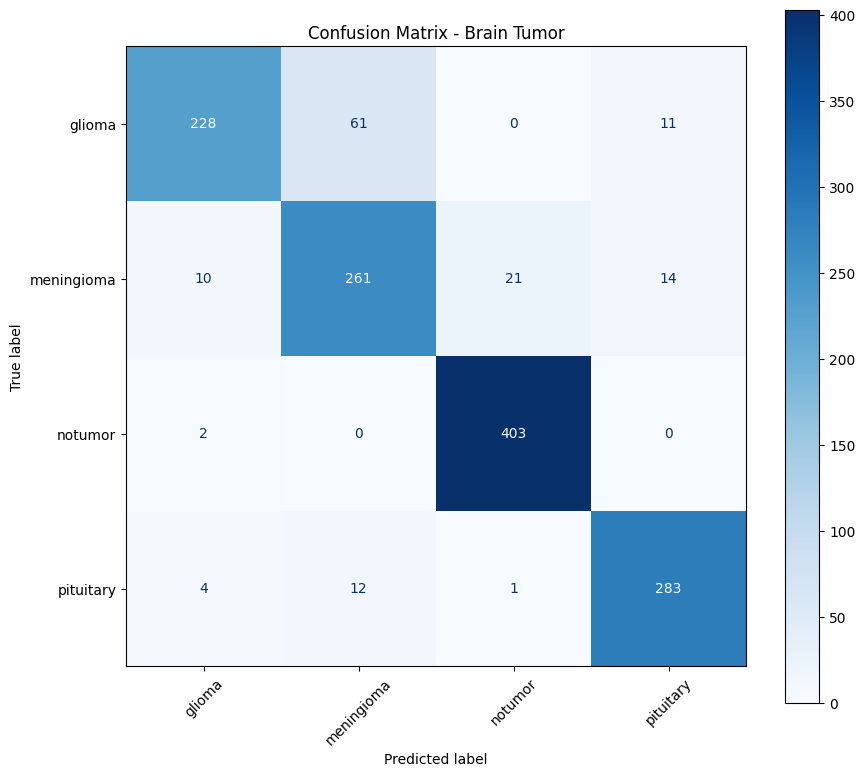

In [31]:
from sklearn.metrics import accuracy_score


model_rf = RandomForestClassifier(random_state=42, n_jobs=N_JOBS, max_depth=9, n_estimators=128)
model_rf.fit(X_train_images, y_train)

y_pred = model_rf.predict(X_test_images)
print(classification_report(y_test, y_pred, digits=5))

accuracy_rf = accuracy_score(y_test, y_pred)

# joblib.dump(model_rf, f"rf_{accuracy_rf}.h5")

cm = confusion_matrix(y_test, y_pred, labels=train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Brain Tumor')
plt.gcf().set_size_inches(10, 9)
plt.show()

              precision    recall  f1-score   support

      glioma    0.88652   0.83333   0.85911       300
  meningioma    0.80678   0.77778   0.79201       306
     notumor    0.93541   0.96543   0.95018       405
   pituitary    0.92089   0.97000   0.94481       300

    accuracy                        0.89245      1311
   macro avg    0.88740   0.88664   0.88653      1311
weighted avg    0.89088   0.89245   0.89119      1311



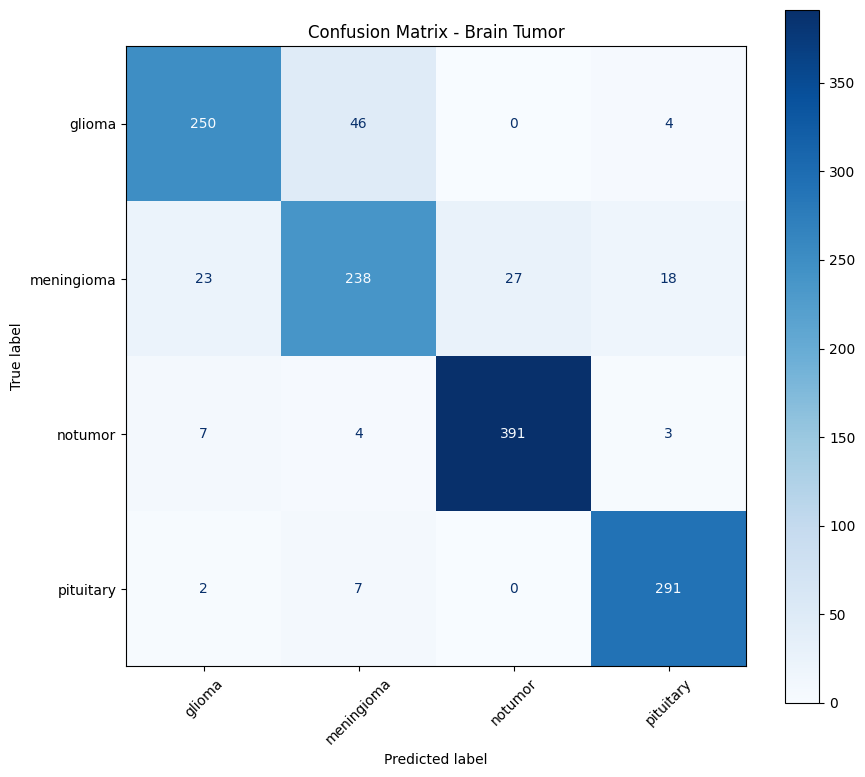

In [28]:
from sklearn.svm import SVC


model_svc = SVC(random_state=42)
model_svc.fit(X_train_pca, y_train)

y_pred = model_svc.predict(X_test_pca)
print(classification_report(y_test, y_pred, digits=5))

cm = confusion_matrix(y_test, y_pred, labels=train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Brain Tumor')
plt.gcf().set_size_inches(10, 9)
plt.show()

              precision    recall  f1-score   support

      glioma    0.72948   0.80000   0.76312       300
  meningioma    0.64255   0.49346   0.55823       306
     notumor    0.85343   0.89136   0.87198       405
   pituitary    0.82099   0.88667   0.85256       300

    accuracy                        0.77651      1311
   macro avg    0.76161   0.76787   0.76147      1311
weighted avg    0.76842   0.77651   0.76939      1311



c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


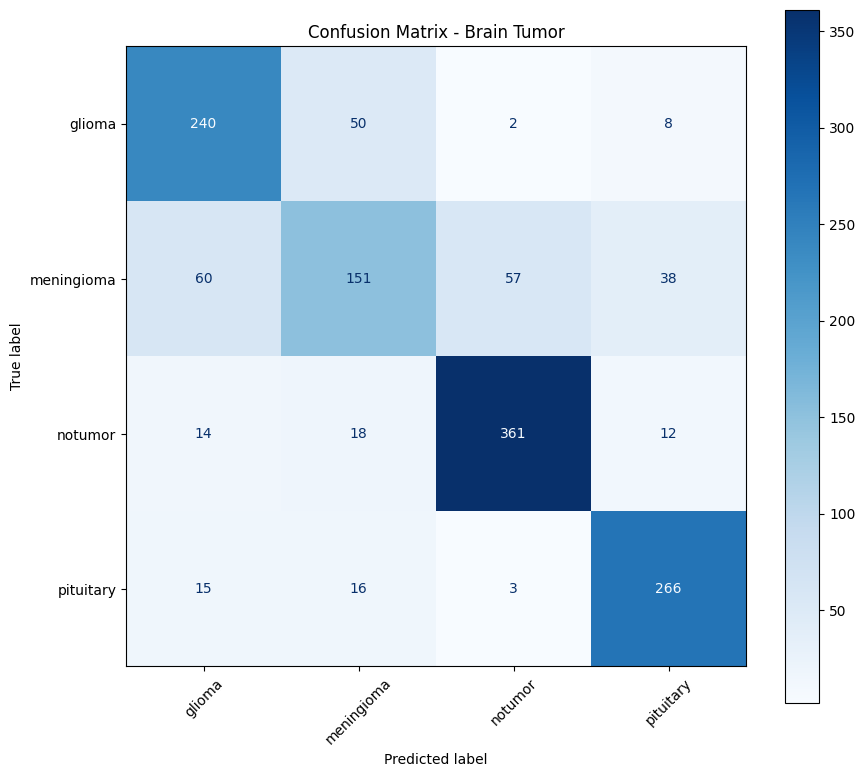

In [ ]:
from sklearn.linear_model import LogisticRegression


model_svc = LogisticRegression(random_state=42)
model_svc.fit(X_train_pca, y_train)

y_pred = model_svc.predict(X_test_pca)
print(classification_report(y_test, y_pred, digits=5))

cm = confusion_matrix(y_test, y_pred, labels=train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Brain Tumor')
plt.gcf().set_size_inches(10, 9)
plt.show()